<a href="https://colab.research.google.com/github/mohamed-habib-jaberi/Deep-Learning/blob/main/Transfer_Learning_RESNET00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bellow are all the imports used in the notebook.

### Tranfer Learning in TensorFlow : Feature extraction

In [159]:
# Common
import os
import keras
import numpy as np
from glob import glob
from tqdm import tqdm


import tensorflow as tf
import datetime
# Data
#from keras.preprocessing.image import ImageDataGenerator

# Data Viz
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Model
from keras import Sequential
from keras.models import load_model
from keras.layers import Dense, GlobalAvgPool2D as GAP, Dropout

# Callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Transfer Learning Models
from tensorflow.keras.applications import ResNet50, ResNet50V2, InceptionV3, Xception, ResNet152, ResNet152V2

### Downloading and becoming one with the data

In [160]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2025-10-10 21:30:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.188.207, 173.194.202.207, 173.194.203.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.188.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M   171MB/s    in 0.9s    

2025-10-10 21:30:07 (171 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [161]:
# How many images in each folder?
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_USE_LEGACY_KERAS"] = "1"  # must be set BEFORE importing TF/Hub

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("/kaggle/input/10-food-classes-10-percent-zip/10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

### Creating data loaders (preparing the data)

Now we've downloaded the data, let's use the ImageDataGenerator class along with the flow_from_directory method to load in our images.

In [162]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


# **Data**

Our first task is to load the **dataset**. Before that let's understand the data.

In [163]:
# Main Path
path = '/content/10_food_classes_10_percent/train'

# Get Class Names
class_names = sorted(os.listdir(path))
n_classes = len(class_names)
print(f"Class Names: \n{class_names}")
print(f"Total Number of Classes : {n_classes}")

Class Names: 
['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']
Total Number of Classes : 10


Their are **10 Classes**, let's have a look at the **Class Distribution**.

In [164]:
class_dis = [len(os.listdir(path + f"/{name}")) for name in class_names]
print(f"Class Distribution : \n{class_dis}")

Class Distribution : 
[75, 75, 75, 75, 75, 75, 75, 75, 75, 75]


It will be better to look at this with **Visualization**.

In [165]:
fig = px.pie(names=class_names, values=class_dis, width=600)
fig.update_layout({"title":{'text':"Class Distribution","x":0.5}})
fig.show()

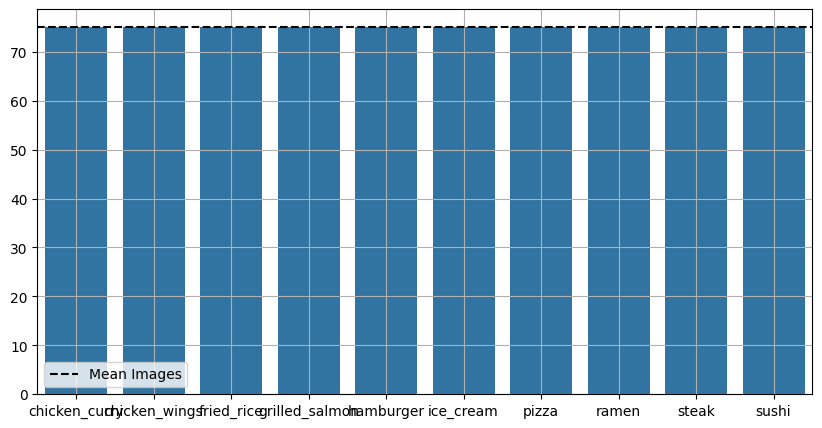

In [166]:
plt.figure(figsize=(10,5))
sns.barplot(x=class_names, y=class_dis)
plt.grid()
plt.axhline(np.mean(class_dis), color='k', linestyle='--', label="Mean Images")
plt.legend()
plt.show()

### Setting up callbacks (things to run whilst our model trains)

Callbacks are tools that add extra functionality during model training, such as tracking progress, saving checkpoints, or stopping early.
We’ll use the TensorBoard callback to visualize and compare our model’s performance.



### Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

In fact, we're going to use  models from Kaggle Model:

[ResNetV2](https://arxiv.org/abs/1603.05027) - a state of the art computer vision model architecture from 2016.


### First we'll import TensorFlow and TensorFlow Hub.

# **Models**

I explored **3 models** with the **same base architecture**. And it turns out that **ResNet152V2** is the **best out of them**. **Xception** had an indication of **growing better**.

In [167]:

# # Specify Model Name
# name = "ResNet152V2"

from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D as GAP, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

name = "ResNet50V2"

base_model = ResNet50V2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False

n_classes = 10  # adjust to your dataset

resnet50V2 = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(n_classes, activation='softmax')
], name=name)

resnet50V2.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Create Tensorboard Callback
cbs = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

In [168]:
# Fit the model
resnet_history = resnet50V2.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks= cbs)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.3280 - loss: 2.0270

24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 802ms/step - accuracy: 0.3344 - loss: 2.0085 - val_accuracy: 0.7416 - val_loss: 0.7783
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8044 - loss: 0.6213

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 392ms/step - accuracy: 0.8046 - loss: 0.6204 - val_accuracy: 0.7676 - val_loss: 0.7083
Epoch 3/5
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8786 - loss: 0.3977

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 377ms/step - accuracy: 0.8797 - loss: 0.3939 - val_accuracy: 0.7648 - val_loss: 0.7032
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 379ms/step - accuracy: 0.9653 - loss: 0.1766 - val_accuracy: 0.7676 - val_loss: 0.7051
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9644 - loss: 0.1377

24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 420ms/step - accuracy: 0.9650 - loss: 0.1371 - val_accuracy: 0.7752 - val_loss: 0.6816


### Model name : "Inception"

In [169]:
# Import necessary Keras modules
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D as GAP, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ✅ Specify a name for this experiment/model
name = "Inception"

# ✅ Load the pretrained InceptionV3 model from ImageNet without its top (classification) layers
#    include_top=False → removes the fully connected classification head
#    input_shape=(224, 224, 3) → defines the expected input image size (height, width, RGB channels)
#    weights='imagenet' → loads pretrained weights learned from the ImageNet dataset
base_model = InceptionV3(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

# ✅ Freeze the base model to prevent its weights from updating during training
base_model.trainable = False

# ✅ Define the number of output classes in your dataset
n_classes = 10  # adjust if you have more or fewer classes

# ✅ Build the final model using Keras Sequential API
#    - base_model: frozen feature extractor
#    - GAP(): converts feature maps into a single vector per image
#    - Dense(256): fully connected layer with 256 neurons for learning new patterns
#    - Dropout(0.2): regularization (drop 20% neurons during training to reduce overfitting)
#    - Dense(n_classes, softmax): output layer that predicts class probabilities
inception = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(n_classes, activation='softmax')
], name=name)

# ✅ Compile the model to configure training settings
#    - loss: 'sparse_categorical_crossentropy' → suitable for integer-encoded labels (0,1,2,…)
#    - optimizer: 'adam' → adaptive learning algorithm
#    - metrics: 'accuracy' → track classification accuracy
inception.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# ✅ Define callbacks to control training behavior
#    - EarlyStopping: stops training if validation accuracy stops improving for 3 epochs
#    - ModelCheckpoint: saves the best model (lowest validation loss) as "Inception.h5"
cbs = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

In [170]:
# Fit the model
inception_history = inception.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks= cbs)

Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.3186 - loss: 2.2362

24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.3243 - loss: 2.2149 - val_accuracy: 0.7192 - val_loss: 0.8248
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7303 - loss: 0.8538

24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 410ms/step - accuracy: 0.7298 - loss: 0.8519 - val_accuracy: 0.7688 - val_loss: 0.6925
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 355ms/step - accuracy: 0.8015 - loss: 0.5719 - val_accuracy: 0.7664 - val_loss: 0.7245
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8482 - loss: 0.4741

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 403ms/step - accuracy: 0.8477 - loss: 0.4749 - val_accuracy: 0.7812 - val_loss: 0.6768
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8817 - loss: 0.3621 - val_accuracy: 0.7732 - val_loss: 0.7075


### Model name : "Xception"

In [179]:
# ✅ Import necessary TensorFlow and Keras modules
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D as GAP, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ✅ Specify a name for this experiment/model
name = "Xception"

# ✅ Load the pretrained Xception model
#    include_top=False → removes the fully connected classification head
#    input_shape=(256,256,3) → input image size and 3 color channels (RGB)
#    weights='imagenet' → use pretrained weights from the ImageNet dataset
base_model = Xception(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

# ✅ Freeze the pretrained base model
#    This ensures only the new layers you add will be trained
base_model.trainable = False

# ✅ Define the number of output classes for your dataset
n_classes = 10  # change this to match your dataset

# ✅ Build your model on top of the frozen feature extractor
#    - GAP(): flattens spatial features into a single vector per image
#    - Dense(256): fully connected layer to learn custom patterns
#    - Dropout(0.2): randomly disables 20% of neurons to reduce overfitting
#    - Dense(n_classes, softmax): output layer producing class probabilities
xception = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(n_classes, activation='softmax')
], name=name)

# ✅ Compile the model
#    - loss: 'sparse_categorical_crossentropy' (for integer labels)
#    - optimizer: 'adam' (efficient adaptive optimizer)
#    - metrics: 'accuracy' (track accuracy during training)
xception.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# ✅ Define training callbacks
#    - EarlyStopping: stop training early if validation loss doesn’t improve for 3 epochs
#    - ModelCheckpoint: save the best model as "Xception.h5"
cbs = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

# ✅ Train the model
#    - train_ds: training dataset
#    - validation_data: validation dataset
#    - epochs=50: number of passes over the dataset
#    - callbacks=cbs: apply early stopping and checkpoint saving
xception_history = xception.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks= cbs)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.3895 - loss: 1.8018

24/24 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.3951 - loss: 1.7850 - val_accuracy: 0.7616 - val_loss: 0.7175
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8005 - loss: 0.6500

24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 541ms/step - accuracy: 0.8005 - loss: 0.6503 - val_accuracy: 0.7932 - val_loss: 0.6206
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8091 - loss: 0.5129

24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 541ms/step - accuracy: 0.8102 - loss: 0.5119 - val_accuracy: 0.7960 - val_loss: 0.6088
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 562ms/step - accuracy: 0.8908 - loss: 0.3706 - val_accuracy: 0.7988 - val_loss: 0.6177
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 515ms/step - accuracy: 0.9405 - loss: 0.2261 - val_accuracy: 0.8024 - val_loss: 0.6099


Training the models for long and with **more dense layers** can **increase the performance**. But due to the **data set size**, the **training is slow** and requires the **GPU**. Overall, it's clear that **ResNet152V2** is the **best model so far**.

Wow!

It seems that after only 5 epochs, the ResNetV250 feature extraction model was able to blow any of the architectures we made out of the water, achieving around 90% accuracy on the training set and nearly 80% accuracy on the test set...with only 10 percent of the training images!

That goes to show the power of transfer learning. And it's one of the main reasons whenever you're trying to model your own datasets, you should look into what pretrained models already exist.

Let's check out our model's training curves using our plot_loss_curves function.

In [171]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

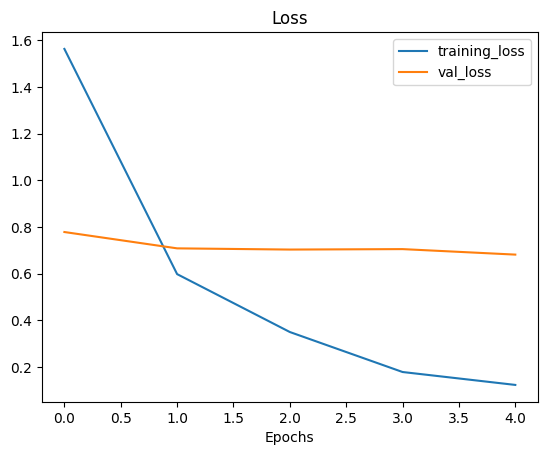

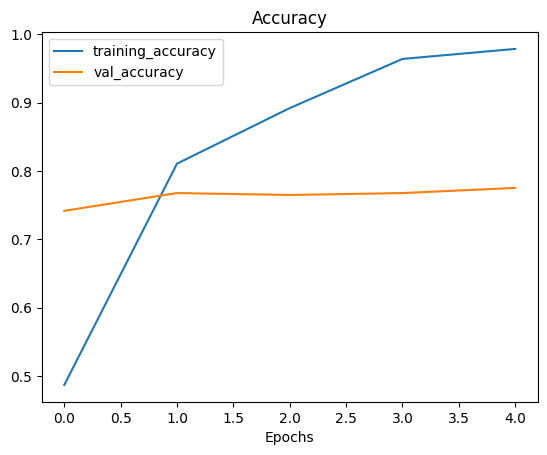

In [172]:
plot_loss_curves(resnet_history)

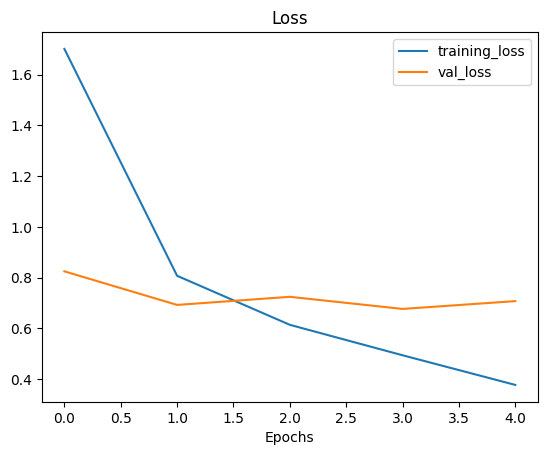

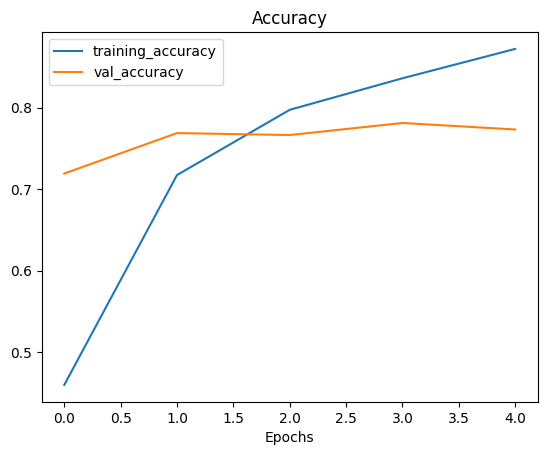

In [178]:
plot_loss_curves(inception_history)

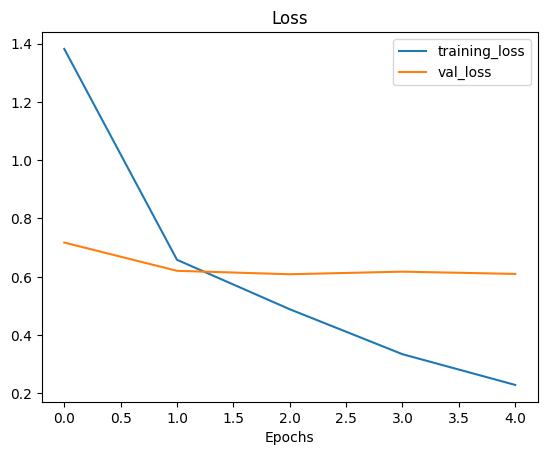

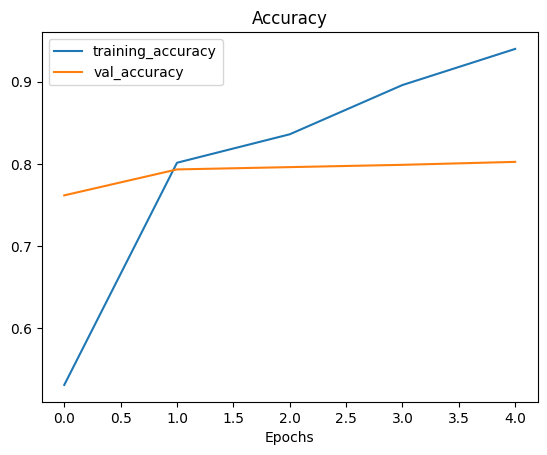

In [180]:
 plot_loss_curves(xception_history)

And what about a summary of our model?

In [173]:
# Resnet summary
resnet50V2.summary()

Model: "ResNet50V2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,146,144 (95.92 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 1,054,230 (4.02 MB)

### Second methode reload and reuse model

In [174]:
import os, pathlib, tensorflow as tf

p = pathlib.Path("/content/ResNet50V2.h5")
print("Exists:", p.exists(), "Size (bytes):", p.stat().st_size if p.exists() else 0)

# Use TensorFlow Keras loader
model = tf.keras.models.load_model(str(p), compile=False)  # compile=False avoids custom-obj issues
model.summary()

Exists: True Size (bytes): 100974632


Model: "ResNet50V2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,091,914 (91.90 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [175]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",  # or "sparse_categorical_crossentropy" depending on your labels
    metrics=["accuracy"]
)

model.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.7800 - loss: 0.7075


[0.6815670728683472, 0.7752000093460083]

# **Prediction Visualization**

In [176]:
def get_random_data(data):
    images, labels = data
    id = np.random.randint(len(images))
    image, label = images[id], labels[id]
    return image, label

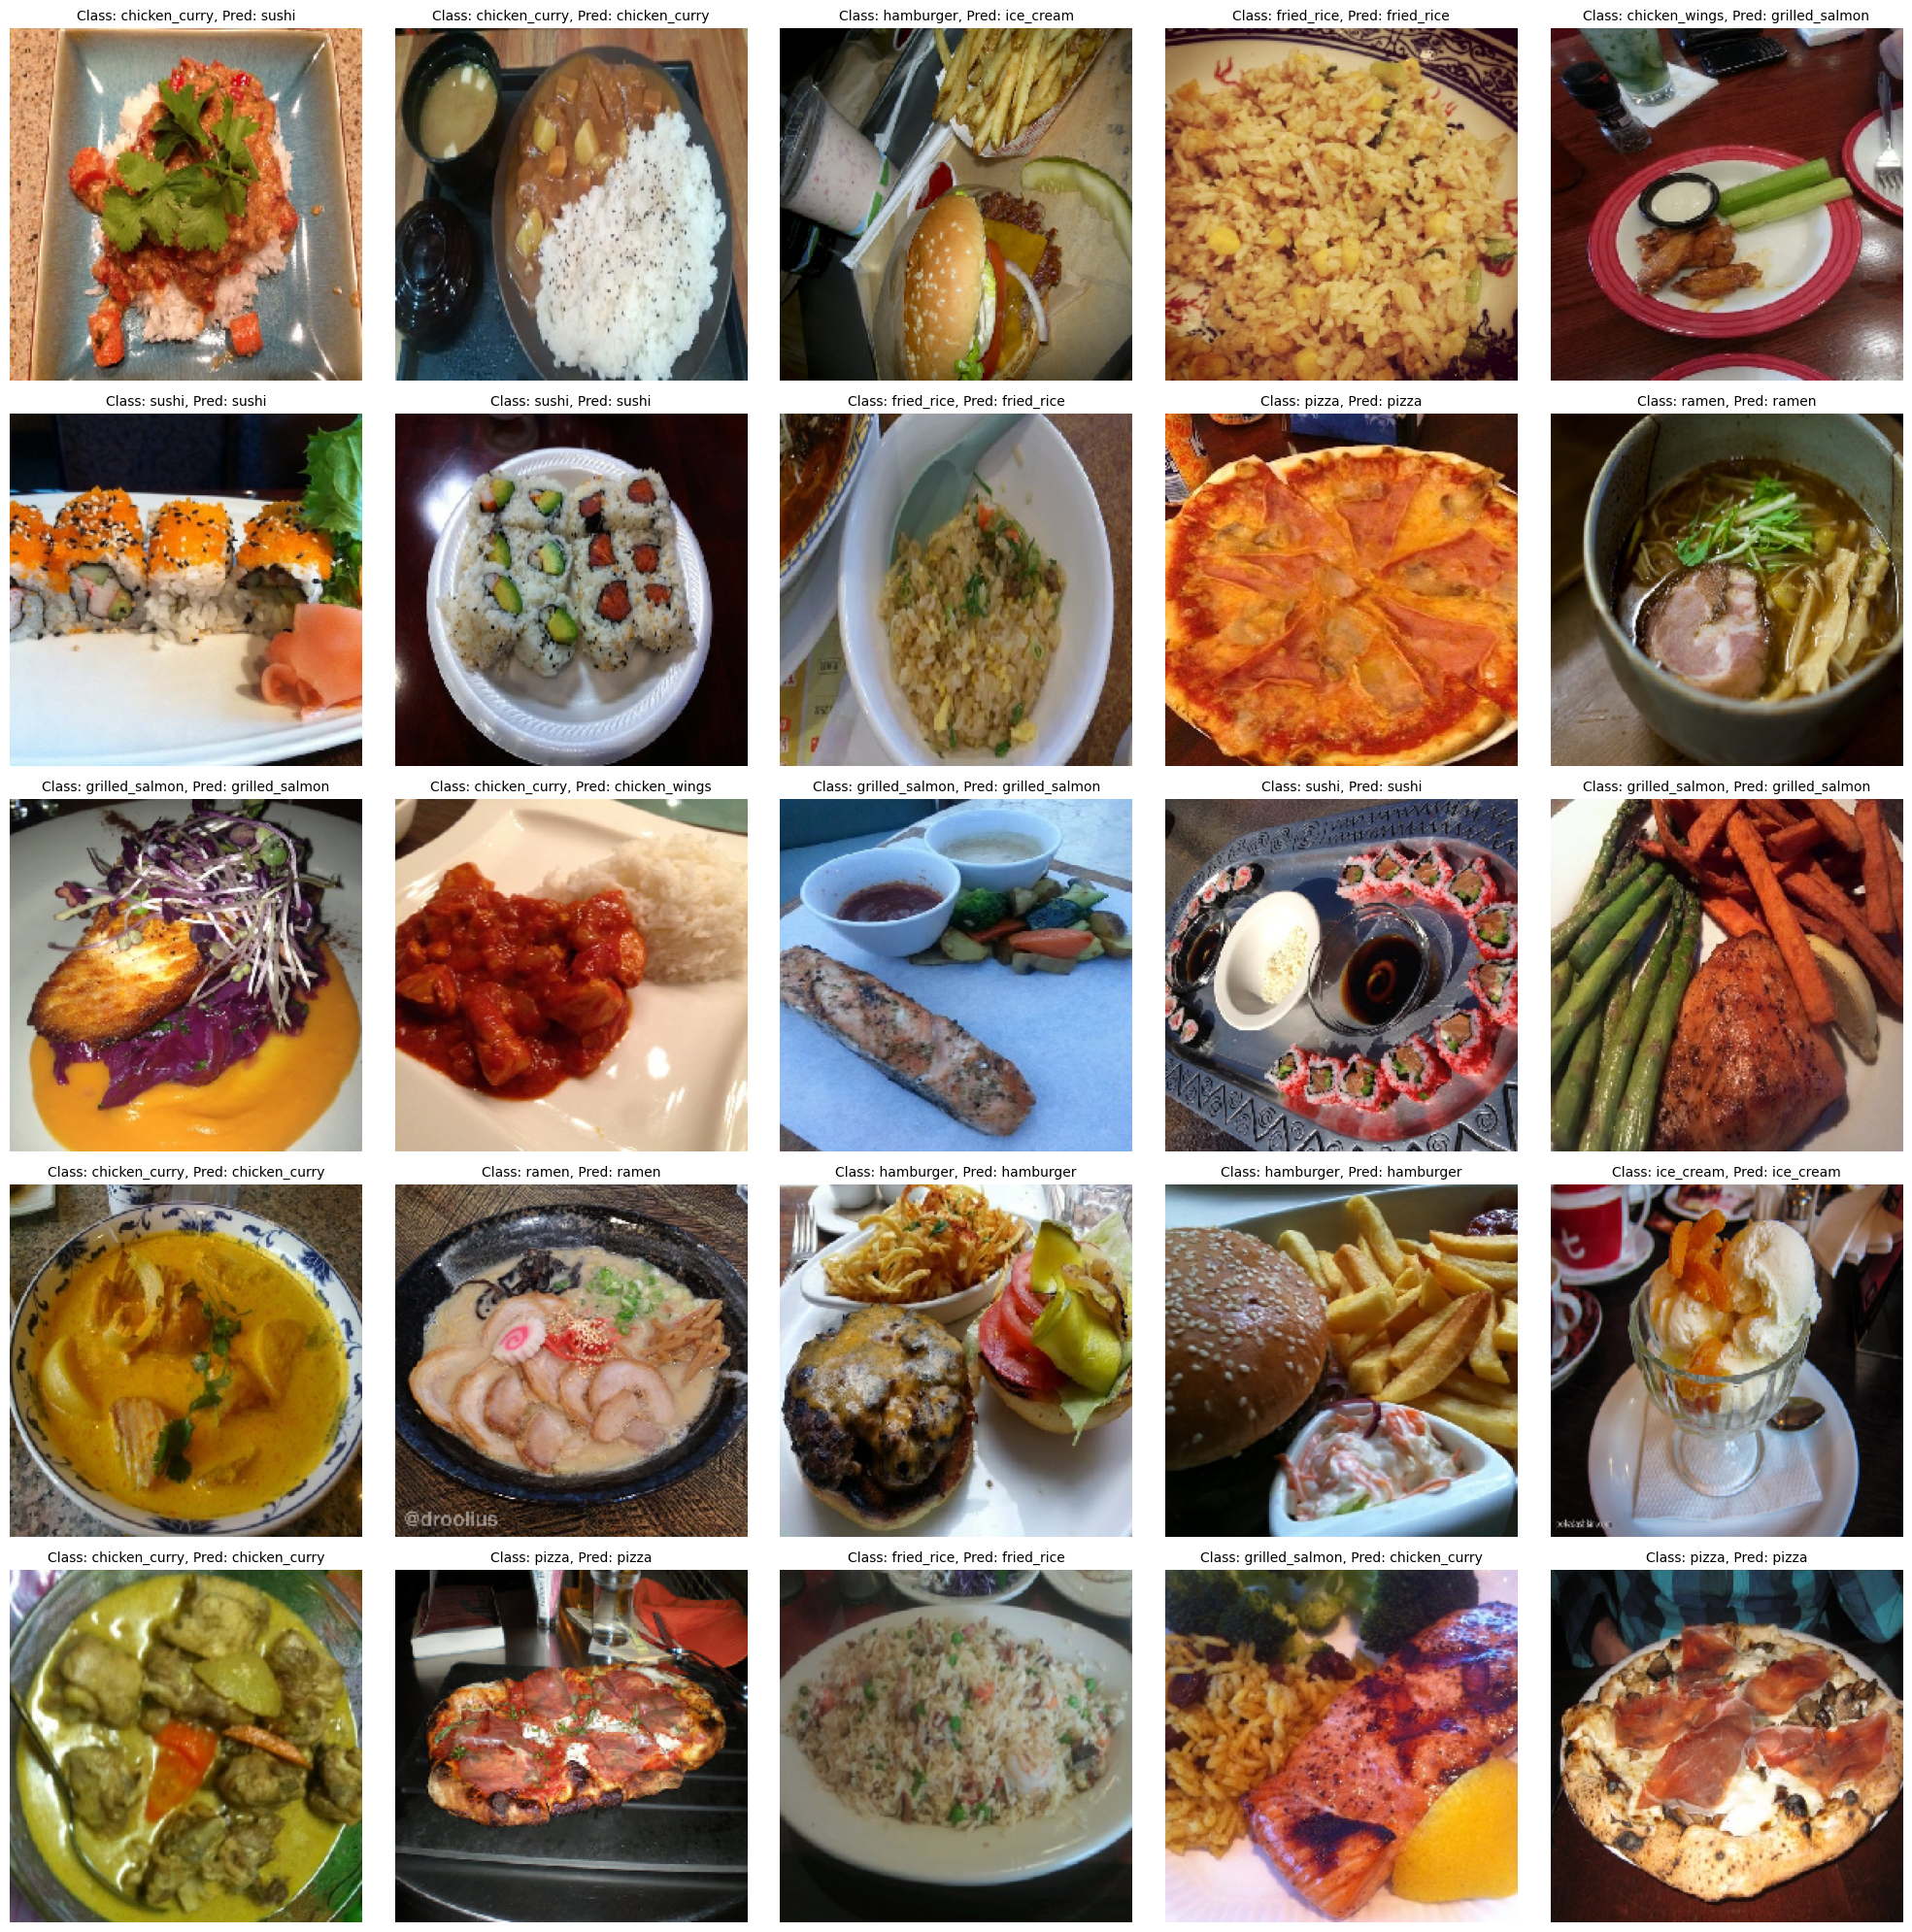

In [177]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def show_image(img, title=""):
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title, fontsize=10)

def get_random_data(batch):
    images, labels = batch
    idx = np.random.randint(0, len(images))
    return images[idx], np.argmax(labels[idx])

plt.figure(figsize=(20,20))
i = 1
for images, labels in iter(test_data):
    image, label = get_random_data([images, labels])
    image256 = tf.image.resize(image, (224, 224))
    probs = model.predict(image256[tf.newaxis, ...], verbose=0)[0]
    pred_label = class_names[int(np.argmax(probs))]
    plt.subplot(5,5,i)
    show_image(image, title=f"Class: {class_names[int(label)]}, Pred: {pred_label}")
    i += 1
    if i >= 26: break

plt.tight_layout()
plt.show()